# Bangkit Final Project: Garbage Classification with Machine Learning

Repository : https://github.com/reevald/craftivity-data

## Import Libraries

In [30]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 1.9MB/s 


In [1]:
import zipfile
import os
import random
import math
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from google.colab import files
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preparation Data with ETL (Extract, Transform, Load)

### Extract Dataset

Source dataset (TrashNet) : https://github.com/garythung/trashnet

In [2]:
# Downloading the Dataset
!wget --no-check-certificate \
  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip \
  -O /tmp/trashnet.zip

--2021-06-03 23:44:18--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘/tmp/trashnet.zip’

/tmp/trashnet.zip   100%[===================>]  40.85M  34.2MB/s    in 1.2s    

2021-06-03 23:44:22 (34.2 MB/s) - ‘/tmp/trashnet.zip’ saved [42834870/42834870]



In [3]:
# Extract the downloaded zip file
local_zip = "/tmp/trashnet.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

# Check the number of datasets
base_dir_ori = "/tmp/dataset-resized"
label = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
list_ori_dir = [base_dir_ori+"/"+lb for lb in label]
for i in range(len(label)):
  print("Data {} : {}".format(label[i], len(os.listdir(list_ori_dir[i]))))

# Preparation of split by configuring directories
base_dir = "/tmp/data"
train_dir = base_dir + "/train"
test_dir = base_dir + "/test"
val_dir = base_dir + "/val"

try:
  # Create directory
  os.mkdir(base_dir)
  for par_dir in [train_dir, test_dir, val_dir]:
    os.mkdir(par_dir)
    for ch_dir in [par_dir+"/"+lb for lb in label]:
      os.mkdir(ch_dir)
  print("\nCreate directory successfully!")
except OSError as e:
  print("\nUnable create directory. {}".format(e))

Data cardboard : 403
Data glass : 501
Data metal : 410
Data paper : 594
Data plastic : 482
Data trash : 137

Create directory successfully!


#### Split Dataset

In [4]:
split = {
         'train' : 0.7,
         'test' : 0.15,
         'val' : 0.15
         }

def split_data(list_class_dir, train_dir, test_dir, val_dir, dict_split, label):
  # Split data for each class
  for idx_lb,class_dir in enumerate(list_class_dir):
    list_img = os.listdir(class_dir)
    list_img = random.sample(list_img, len(list_img))
    if (dict_split['train']+dict_split['test']+dict_split['val']==1.0):
      num_val = math.floor(dict_split['val'] * len(list_img))
      num_test = math.floor(dict_split['test'] * len(list_img))
      num_train = len(list_img) - num_val - num_test
      for i in range(len(list_img)):
        # Check image
        size_file_img = os.path.getsize(class_dir+"/"+list_img[i])
        if (size_file_img == 0):
          continue
        if (i < num_val):
          # Copy to val dir
          dest_dir = val_dir
        elif (i >= num_val and i < num_val + num_test):
          # Copy to test dir
          dest_dir = test_dir
        else:
          # Copy to train dir
          dest_dir = train_dir
        try:
          copyfile(class_dir+"/"+list_img[i], dest_dir+"/"+label[idx_lb]+"/"+list_img[i])
        except IOError as e:
          return "Unable to copy file. {}".format(e)
    else:
      return "Incorrect data split!"

    print("{} : train({}), test({}), val({})".format(
        label[idx_lb],
        len(os.listdir(train_dir+"/"+label[idx_lb])),
        len(os.listdir(test_dir+"/"+label[idx_lb])),
        len(os.listdir(val_dir+"/"+label[idx_lb]))
    ))

# Check the split results
split_data(
    list_class_dir=[base_dir_ori+"/"+lb for lb in label],
    train_dir=train_dir,
    test_dir=test_dir,
    val_dir=val_dir,
    dict_split=split,
    label=label
)

cardboard : train(283), test(60), val(60)
glass : train(351), test(75), val(75)
metal : train(288), test(61), val(61)
paper : train(416), test(89), val(89)
plastic : train(338), test(72), val(72)
trash : train(97), test(20), val(20)


TODO : Create visualize distribution

Delete data (if there are errors or duplicate files) and start from the configuration directory  
`%rm -rf "/tmp/data"`

### Transform Dataset

Reference for batch size, epoch, and learning rate :  
https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e  


In [5]:
# Corresponds to a lot of data
batch_train = 32 # Alternative : 8,16,32,64
batch_val = 16
batch_test = 16
size_input = (224, 224)

# Normalize image
valtest_datagen = ImageDataGenerator(rescale=1./255.)

#### Augmentation

Reference for augmentation :  
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [6]:
# Image augmentation (optional to improve accuracy)
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Load Dataset

In [7]:
# Train Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_train,
    class_mode='categorical',
    target_size=size_input
)

# Test Generator
test_generator = valtest_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_test,
    class_mode='categorical',
    target_size=size_input
)

# Val Generator
val_generator = valtest_datagen.flow_from_directory(
    directory=val_dir,
    batch_size=batch_val,
    class_mode='categorical',
    target_size=size_input
)

Found 1773 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


#### Visualize Data

Reference subplot multi image :  
https://matplotlib.org/stable/gallery/images_contours_and_fields/multi_image.html

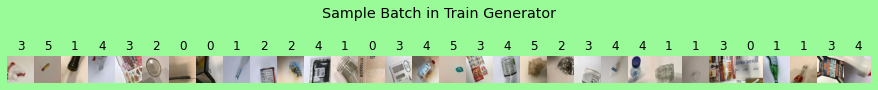

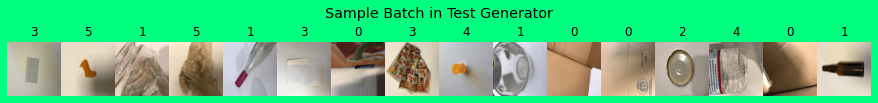

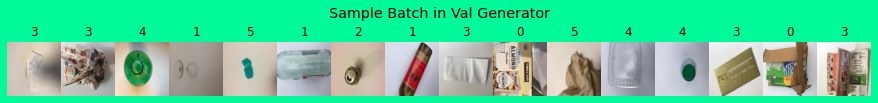

In [8]:
# Take a sample batch file
idx_train = random.randrange(len(train_generator))
idx_test = random.randrange(len(test_generator))
idx_val = random.randrange(len(val_generator))

# Displays an image with label for the train, test and val generator
list_train_img, list_train_lb = train_generator[idx_train]
list_test_img, list_test_lb = test_generator[idx_test]
list_val_img, list_val_lb = val_generator[idx_val]

# The number of images must be less than or equal to the batch size
def show_img_horizontal(title, color, list_img, list_lb, num_img):
  fig = plt.figure(figsize=(12,1.8), facecolor=color)
  fig.suptitle(title, fontsize='x-large')
  axs = fig.subplots(1, num_img)
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  for i in range(num_img):
    axs[i].imshow(list_img[i])
    axs[i].axis('off')
    axs[i].title.set_text(np.argmax(list_lb[i]))

# Show image in train generator
show_img_horizontal(
    'Sample Batch in Train Generator',
    'palegreen',
    list_train_img,
    list_train_lb,
    batch_train
)
# Show image in test generator
show_img_horizontal(
    'Sample Batch in Test Generator',
    'springgreen',
    list_test_img,
    list_test_lb,
    batch_test
)
# Show image in test generator
show_img_horizontal(
    'Sample Batch in Val Generator',
    'mediumspringgreen',
    list_val_img,
    list_val_lb,
    batch_val
)

<table>
  <tr>
    <th colspan="6">Label Code</th>
  </tr>
  <tr align="center">
    <td>0</td>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>4</td>
    <td>5</td>
  </tr>
  <tr>
    <td>Cardboard</td>
    <td>Glass</td>
    <td>Metal</td>
    <td>Paper</td>
    <td>Plastic</td>
    <td>Trash</td>
  </tr>
</table>

## Model with Transfer Learning (with MobileNet v2)

Why MobileNet v2?  
The main reason is because MobileNetv2 is lightweight for deployment to smartphones (tflite) ~ 14 MB  

Reference : 
- https://keras.io/api/applications/#usage-examples-for-image-classification-models
- https://keras.io/guides/transfer_learning/
- https://analyticsindiamag.com/a-practical-guide-to-implement-transfer-learning-in-tensorflow/#:~:text=Transfer%20Learning%20With%20MobileNet%20V2,images%20of%20cats%20and%20dogs.

### Create and Train Model

First, instantiate a base model with pre-trained weights.

In [9]:
# The base model is the model that is pre-trained. 
# We will create a base model using MobileNet V2.

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=size_input+(3,),
    include_top=False  # Do not include the ImageNet classifier at the top.
)

9412608/9406464 [==============================] - 0s 0us/step


Then, to implement fine-tuning of the whole base model, Unfreeze the base model.

In [10]:
# Unfreeze the base model.
base_model.trainable = True

Create a new model on top.

In [11]:

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax')]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


Train the model on new data.

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [13]:
# ref : https://stackoverflow.com/questions/53500047/stop-training-in-keras-when-accuracy-is-already-1-0
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["categorical_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True
            
callback = MyThresholdCallback(threshold=1.0)

In [14]:
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[callback],
    verbose=1
)

Epoch 1/30
56/56 [==============================] - 321s 6s/step - loss: 1.8712 - categorical_accuracy: 0.2352 - val_loss: 2.2152 - val_categorical_accuracy: 0.1273
Epoch 2/30
56/56 [==============================] - 312s 6s/step - loss: 1.4358 - categorical_accuracy: 0.4399 - val_loss: 1.9412 - val_categorical_accuracy: 0.2175
Epoch 3/30
56/56 [==============================] - 319s 6s/step - loss: 1.1977 - categorical_accuracy: 0.5742 - val_loss: 1.7082 - val_categorical_accuracy: 0.3210
Epoch 4/30
56/56 [==============================] - 318s 6s/step - loss: 1.0105 - categorical_accuracy: 0.6458 - val_loss: 1.5477 - val_categorical_accuracy: 0.4111
Epoch 5/30
56/56 [==============================] - 325s 6s/step - loss: 0.9198 - categorical_accuracy: 0.6926 - val_loss: 1.4294 - val_categorical_accuracy: 0.4509
Epoch 6/30
56/56 [==============================] - 314s 6s/step - loss: 0.8098 - categorical_accuracy: 0.7360 - val_loss: 1.3233 - val_categorical_accuracy: 0.4960
Epoch 7/30

### Plot Accuracy and Lose

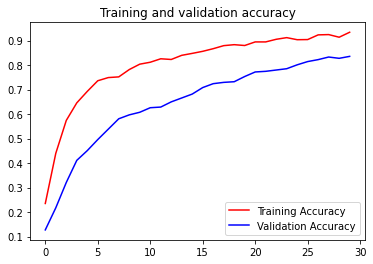

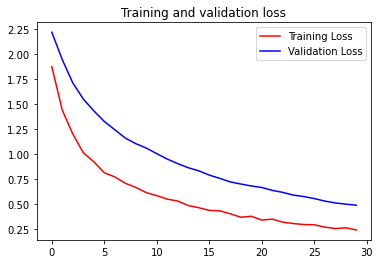

In [15]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Test Accuracy Model

In [16]:
loss = model.evaluate(test_generator, steps=len(test_generator))

24/24 [==============================] - 10s 425ms/step - loss: 0.3933 - categorical_accuracy: 0.8753


### Visualize accuracy each label or class with confusion matrix

reference : https://datatofish.com/confusion-matrix-python/

In [17]:
# FIXED index order classes (https://github.com/keras-team/keras/issues/4225)
# Create new test generator with shuffle=False
new_test_generator = valtest_datagen.flow_from_directory(
    directory=test_dir,
    batch_size=batch_test,
    class_mode='categorical',
    target_size=size_input,
    shuffle=False # important part
)
new_test_generator.classes

Found 377 images belonging to 6 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [18]:
predictions = model.predict(new_test_generator, steps=len(new_test_generator))

In [19]:
# [FIXED] Problem order classes with set shuffle=False in test_generator
predictions_lb = np.argmax(predictions,axis=1)
print(predictions_lb)

[0 0 0 0 0 0 3 2 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 3 0 0
 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 5 0 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 4 1 1 1 4 1 1 1 1 2 4 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 4 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 1 2 2
 1 2 2 2 1 2 2 2 2 2 2 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 4 1 4 4 4 4 3 4 1 4
 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 3 4 4 4 4 4 4 3 5 4 5 5 1 5 5 5 2 5 1 5 5
 5 5 3 2 3 0 5]


In [20]:
labels = new_test_generator.classes
confusion_matrix = tf.math.confusion_matrix(labels, predictions_lb)
print(confusion_matrix)

tf.Tensor(
[[52  0  1  5  1  1]
 [ 0 67  3  0  5  0]
 [ 0  6 53  0  2  0]
 [ 0  0  2 83  4  0]
 [ 0  4  1  3 63  1]
 [ 1  2  2  2  1 12]], shape=(6, 6), dtype=int32)


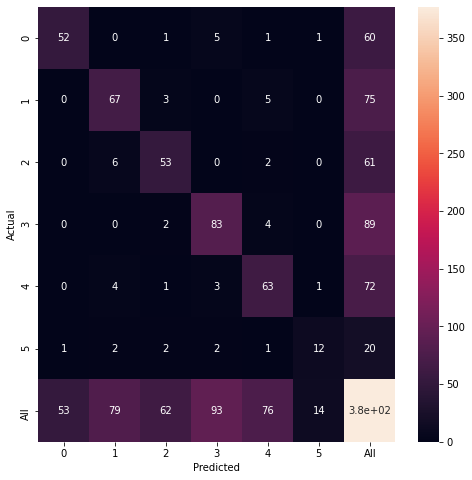

In [21]:
data = {'y_Actual': labels,
        'y_Predicted': predictions_lb
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
plt.figure(figsize = (8,8))
sn.heatmap(confusion_matrix, annot=True)
plt.show()

<table>
  <tr>
    <th colspan="6">Label Code</th>
  </tr>
  <tr align="center">
    <td>0</td>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>4</td>
    <td>5</td>
  </tr>
  <tr>
    <td>Cardboard</td>
    <td>Glass</td>
    <td>Metal</td>
    <td>Paper</td>
    <td>Plastic</td>
    <td>Trash</td>
  </tr>
</table>

More Details

In [22]:
report = metrics.classification_report(
    labels, 
    predictions_lb, 
    target_names=label
)
print(report)

              precision    recall  f1-score   support

   cardboard       0.98      0.87      0.92        60
       glass       0.85      0.89      0.87        75
       metal       0.85      0.87      0.86        61
       paper       0.89      0.93      0.91        89
     plastic       0.83      0.88      0.85        72
       trash       0.86      0.60      0.71        20

    accuracy                           0.88       377
   macro avg       0.88      0.84      0.85       377
weighted avg       0.88      0.88      0.87       377



## Exporting and Optimization to TFJS

Reference :  
- https://medium.com/hackernoon/tf-serving-keras-mobilenetv2-632b8d92983c
- https://itnext.io/shrink-your-tensorflow-js-web-model-size-with-weight-quantization-6ddb4fcb6d0d

In [23]:
# Specifies the model directory
model_dir = '/tmp/model'
try:
  os.mkdir(model_dir)
except OSError as e:
  print("\nUnable create directory. {}".format(e))

In [25]:
# Save model .h5
model_name = "model_mbv2"
model.save(model_dir+f"/{model_name}.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
# Download model .h5, for backup
files.download('/tmp/model/model_mbv2.h5')

print('`model_mbv2.h5` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`model_mbv2.h5` has been downloaded


Export .h5 model to tfjs model  
Reference : https://huningxin.github.io/tfjs-converter/

In [32]:
!tensorflowjs_converter \
    --input_format=keras \
    /tmp/model/model_mbv2.h5 \
    /tmp/tfjs_float_model

2021-06-04 03:11:30.029159: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Optimization using quantization  
Reference : https://stackoverflow.com/questions/63949766/how-can-i-quantize-a-keras-model-while-converting-it-to-a-tensorflowjs-layers-mo



In [49]:
!tensorflowjs_converter \
    --quantize_uint8 \
    --input_format=keras \
    /tmp/model/model_mbv2.h5 \
    /tmp/tfjs_quant_model

2021-06-04 03:32:49.449121: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0




---



### Download TFJS Model

Float Model

In [51]:
!zip -r /tmp/tfjs_float_model.zip /tmp/tfjs_float_model

  adding: tmp/tfjs_float_model/ (stored 0%)
  adding: tmp/tfjs_float_model/group1-shard1of3.bin (deflated 7%)
  adding: tmp/tfjs_float_model/model.json (deflated 96%)
  adding: tmp/tfjs_float_model/group1-shard2of3.bin (deflated 7%)
  adding: tmp/tfjs_float_model/group1-shard3of3.bin (deflated 7%)


In [53]:
# Download the garbage detection model
files.download('/tmp/tfjs_float_model.zip')

print('`tfjs_float_model.zip` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`tfjs_float_model.zip` has been downloaded


Quantization Model

In [55]:
!zip -r /tmp/tfjs_quant_model.zip /tmp/tfjs_quant_model

  adding: tmp/tfjs_quant_model/ (stored 0%)
  adding: tmp/tfjs_quant_model/group1-shard1of1.bin (deflated 20%)
  adding: tmp/tfjs_quant_model/model.json (deflated 92%)


In [56]:
# Download the garbage detection model
files.download('/tmp/tfjs_quant_model.zip')

print('`tfjs_quant_model.zip` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`tfjs_quant_model.zip` has been downloaded


## Summary

<table>
<tr><th >TEST ACCURACY<br/><br/>with 70/15/15 ~ train/val/test</th></tr>
<tr>
  <td>w/ Transfer learning</td>
</tr>
<tr>
  <td>87.53%</td>
</tr>
</table>

Size comparison

In [72]:
def get_size_dir(dir):
    total_size = 0
    for dir_path, _, filenames in os.walk(dir):
        for f in filenames:
            fp = os.path.join(dir_path, f)
            total_size += os.path.getsize(fp)
    return total_size

In [73]:
float_size = get_size_dir('/tmp/tfjs_float_model')/1024 #KBs
quant_size = get_size_dir('/tmp/tfjs_quant_model')/1024 #KBs
print("tfjs_float_size = %dKBs" % float_size)
print("tfjs_quant_size = %dKBs" % quant_size)

tfjs_float_size = 8950KBs
tfjs_quant_size = 2344KBs


<table>
<tr>
  <td>Float Model</td>
  <td>Quantization Model</td>
</tr>
<tr>
<th colspan=2>TOTAL MODEL SIZE (FOLDER)<br><br>(model.json & group*-shard*.bin)</th>
</tr>
<tr>
<td>8950KBs</td>
<td>2344KBs</td>
</tr>
</table>